In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [3]:
def show_image(img, title="Image"):
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


In [4]:
def capture_face():
    cap = cv2.VideoCapture(0)

    print("📸 Press SPACE to capture the face image")
    print("❌ Press ESC to exit")

    captured_face = None

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Camera not detected.")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        # Draw box around detected face
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        cv2.imshow("Webcam - Press SPACE to Capture", frame)
        key = cv2.waitKey(1)

        # SPACE key → capture face
        if key == 32:
            if len(faces) > 0:
                x, y, w, h = faces[0]
                captured_face = frame[y:y+h, x:x+w]
                print("✔ Face Captured!")
                break
            else:
                print("⚠ No face detected. Try again.")

        # ESC key → exit
        elif key == 27:
            print("❌ Capture Cancelled")
            break

    cap.release()
    cv2.destroyAllWindows()
    return captured_face


📸 Press SPACE to capture the face image
❌ Press ESC to exit
✔ Face Captured!


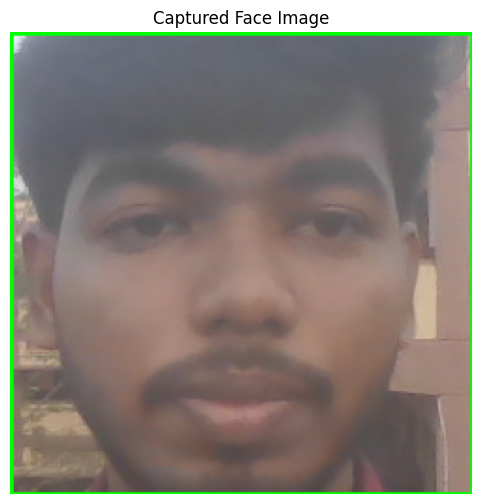

In [5]:
raw_image = capture_face()

if raw_image is not None:
    show_image(raw_image, "Captured Face Image")
else:
    print("No image captured.")


In [6]:
np.save("raw_image.npy", raw_image)

In [9]:
pip install --upgrade requests urllib3 charset-normalizer idna


  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached urllib3-2.6.2-py3-none-any.whl.metadata (6.6 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached urllib3-2.6.2-py3-none-any.whl (131 kB)
Using cached idna-3.11-py3-none-any.whl (71 kB)

  Attempting uninstall: urllib3

    Found existing installation: urllib3 2.5.0

    Uninstalling urllib3-2.5.0:

      Successfully uninstalled urllib3-2.5.0

   ---------------------------------------- 0/4 [urllib3]
   ---------------------------------------- 0/4 [urllib3]
  Attempting uninstall: idna
   ---------------------------------------- 0/4 [urllib3]
    Found existing installation: idna 2.10
   ---------------------------------------- 0/4 [urllib3]
    Uninstalling idna-2.10:
   ---------------------------------------- 0/4 [urllib3]
      Successfully uninstalled idna-2.10
   ---------------------------------------- 0/4 [urllib3]
   --

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
httpx 0.13.3 requires idna==2.*, but you have idna 3.11 which is incompatible.
jupyterlab 4.4.4 requires httpx>=0.25.0, but you have httpx 0.13.3 which is incompatible.


In [10]:
import idna
import requests
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    "skin2",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_data = datagen.flow_from_directory(
    "skin2",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 1388 images belonging to 5 classes.
Found 346 images belonging to 5 classes.


In [12]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model.layers:
    layer.trainable = False


In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

output = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10


C:\ProgramData\anaconda3\envs\opencv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - accuracy: 0.4179 - loss: 1.3564 - val_accuracy: 0.6243 - val_loss: 0.9530
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step - accuracy: 0.6138 - loss: 0.9763 - val_accuracy: 0.7225 - val_loss: 0.8062
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.6801 - loss: 0.8185 - val_accuracy: 0.7486 - val_loss: 0.7202
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - accuracy: 0.7399 - loss: 0.7187 - val_accuracy: 0.7572 - val_loss: 0.6694
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.7579 - loss: 0.6398 - val_accuracy: 0.7514 - val_loss: 0.6387
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.7774 - loss: 0.6015 - val_accuracy: 0.7659 - val_loss: 0.6166
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.7983 - loss: 0.5412 - val_accuracy: 0.7659 - val_loss: 0.6055
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.8033 - loss: 0.5229 - val_accuracy: 0.789

In [16]:
model.save("skin_type_mobilenetv2.h5")
print("✅ Model saved")

✅ Model saved


In [17]:
import cv2
import numpy as np

def preprocess_for_cnn(face_img):
    face_img = cv2.resize(face_img, (224, 224))   
    face_img = face_img.astype("float32") / 255.0 
    face_img = np.expand_dims(face_img, axis=0)   
    return face_img

cnn_ready_image = preprocess_for_cnn(raw_image)

np.save("raw_image.npy", cnn_ready_image)
print("✔ Image saved as raw_image.npy with shape:", cnn_ready_image.shape)


✔ Image saved as raw_image.npy with shape: (1, 224, 224, 3)


In [18]:
import sqlite3

conn = sqlite3.connect("wellness.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS wellness (
    skin_type TEXT PRIMARY KEY,
    skin_care TEXT,
    nutrition TEXT,
    lifestyle TEXT
)
""")

professional_data = [
    (
        "oily skin",
        "Use a mild, oil‑free cleanser twice daily. Prefer non‑comedogenic skincare products and avoid heavy creams.",
        "Limit intake of oily and high‑glycemic foods. Increase consumption of vegetables, fruits, and water.",
        "Maintain facial hygiene, avoid frequent touching of the face, and manage stress through relaxation techniques."
    ),

    (
        "dry skin",
        "Apply a gentle, hydrating cleanser and a moisturizer containing ceramides or hyaluronic acid regularly.",
        "Consume foods rich in healthy fats such as nuts, seeds, and fish. Ensure adequate daily water intake.",
        "Avoid prolonged hot showers, use a humidifier in dry environments, and ensure sufficient sleep."
    ),

    (
        "normal skin",
        "Follow a consistent skincare routine including cleansing, moisturizing, and sun protection.",
        "Maintain a balanced diet rich in vitamins, minerals, and antioxidants.",
        "Practice regular physical activity, maintain good sleep hygiene, and manage daily stress effectively."
    ),


    (
        "acne skin",
        "Use fragrance‑free, hypoallergenic skincare products and perform patch tests before new applications.",
        "Avoid spicy or highly processed foods and include antioxidant‑rich fruits and vegetables.",
        "Minimize sun exposure, reduce stress levels, and avoid harsh environmental conditions."
    )
]

cursor.executemany("""
INSERT OR REPLACE INTO wellness VALUES (?, ?, ?, ?)
""", professional_data)

conn.commit()
conn.close()

print("✔ Professional wellness database created successfully")


✔ Professional wellness database created successfully


In [19]:
def get_wellness_advice(skin_type):
    conn = sqlite3.connect("wellness.db")
    cursor = conn.cursor()

    cursor.execute("""
    SELECT skin_care, nutrition, lifestyle
    FROM wellness
    WHERE skin_type = ?
    """, (skin_type.lower(),))

    result = cursor.fetchone()
    conn.close()

    if result:
        return {
            "Skin Care Recommendation": result[0],
            "Nutritional Guidance": result[1],
            "Lifestyle Suggestions": result[2]
        }
    else:
        return None


In [20]:

cnn_input = np.load("raw_image.npy")

print("CNN Input Shape:", cnn_input.shape)  # must be (1,224,224,3)

prediction = model.predict(cnn_input)
predicted_class = np.argmax(prediction)

class_labels = list(train_data.class_indices.keys())
print("Predicted Skin Type:", class_labels[predicted_class])

predicted_skin = class_labels[predicted_class]

advice = get_wellness_advice(predicted_skin)

print("\n🧾 PERSONALIZED WELLNESS REPORT")
print("Predicted Skin Type:", predicted_skin.capitalize())

if advice:
    for section, text in advice.items():
        print(f"\n🔹 {section}")
        print(text)
else:
    print("No wellness data available for the predicted skin type.")


CNN Input Shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Skin Type: dry skin

🧾 PERSONALIZED WELLNESS REPORT
Predicted Skin Type: Dry skin

🔹 Skin Care Recommendation
Apply a gentle, hydrating cleanser and a moisturizer containing ceramides or hyaluronic acid regularly.

🔹 Nutritional Guidance
Consume foods rich in healthy fats such as nuts, seeds, and fish. Ensure adequate daily water intake.

🔹 Lifestyle Suggestions
Avoid prolonged hot showers, use a humidifier in dry environments, and ensure sufficient sleep.


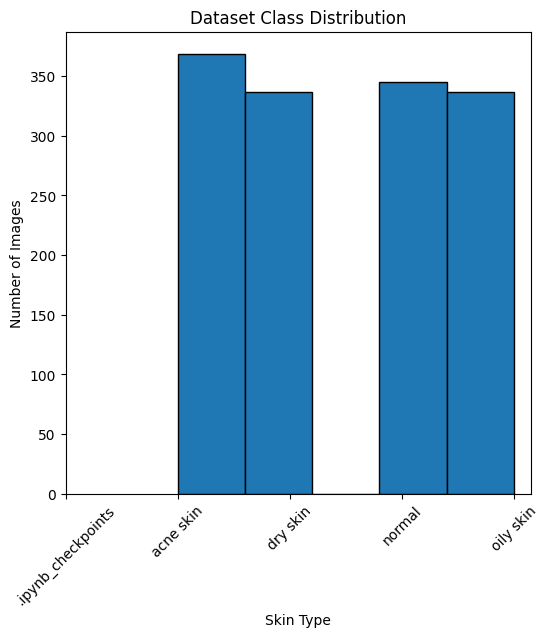

In [21]:
import matplotlib.pyplot as plt

class_counts = train_data.classes
labels = list(train_data.class_indices.keys())

plt.figure(figsize=(6,6))
plt.hist(class_counts, bins=len(labels), edgecolor='black')
plt.xticks(range(len(labels)), labels, rotation=45)
plt.title("Dataset Class Distribution")
plt.xlabel("Skin Type")
plt.ylabel("Number of Images")
plt.show()

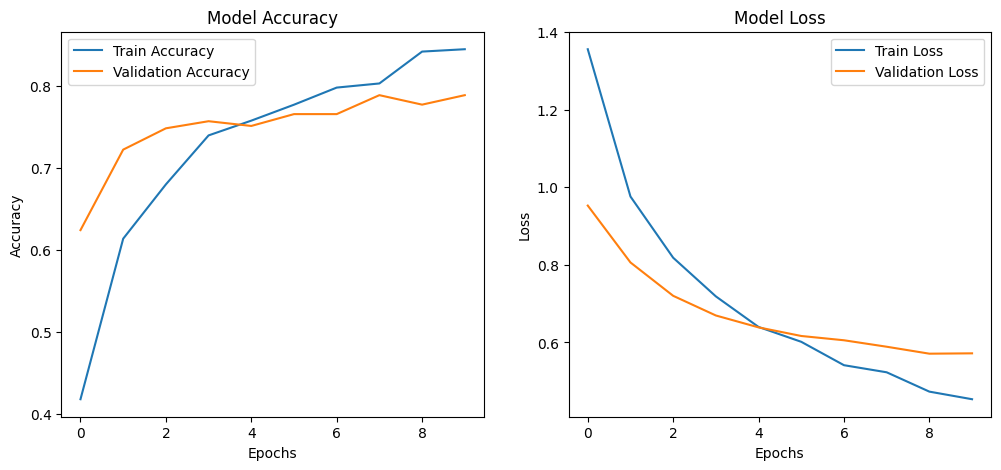

In [22]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [23]:
!pip install seaborn

87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step


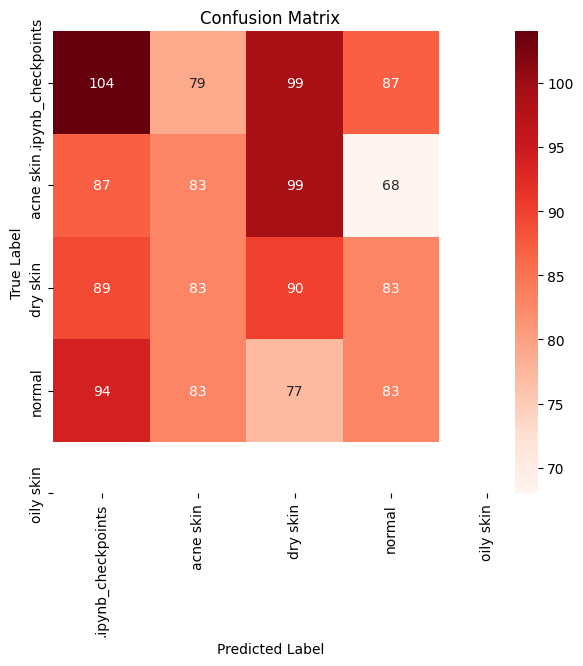

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = train_data.classes
y_pred = np.argmax(model.predict(train_data), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=labels,
            yticklabels=labels,
            cmap='Reds')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


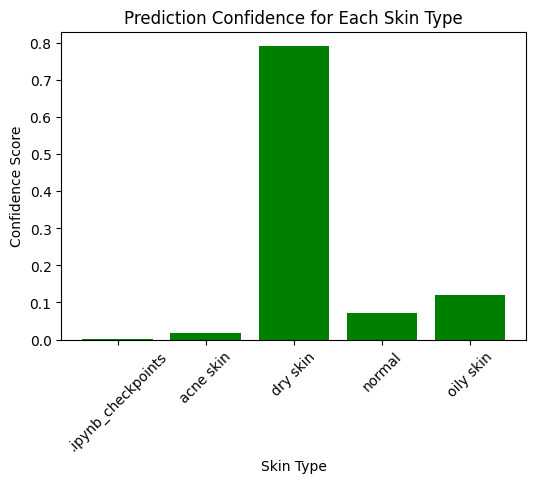

In [25]:
prediction = model.predict(cnn_input)[0]

plt.figure(figsize=(6,4))
plt.bar(labels, prediction, color='green')
plt.title("Prediction Confidence for Each Skin Type")
plt.xlabel("Skin Type")
plt.ylabel("Confidence Score")
plt.xticks(rotation=45)
plt.show()
